<a href="https://colab.research.google.com/github/brunotech/Audiovisual-Synthesis/blob/master/Talk_to_Edit_with_dialog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Talk-to-Edit: Fine-Grained Facial Editing via Dialog (ICCV2021)

In this demo, you can try to edit synthesized images by talking to the system.

In [ ]:
#@title Setup (may take some time)

# install 
!pip install ninja
!pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 -f https://download.pytorch.org/whl/torch_stable.html 

# prepare code
!git clone https://github.com/yumingj/Talk-to-Edit.git 
import os
os.chdir('Talk-to-Edit')

# download pretrained model
os.chdir('download')
!wget -c https://www.dropbox.com/s/pvyj2thomztvjwx/pretrained_models.zip?dl=0 -O pretrained_models.zip
!unzip pretrained_models.zip
!rm -rf pretrained_models.zip
os.chdir('..')

# set up code
import argparse
import json
import logging
import os.path
import random

import numpy as np
import torch

from models import create_model
from utils.dialog_edit_utils import dialog_with_real_user
from utils.logger import get_root_logger
from utils.options import (dict2str, dict_to_nonedict, parse,
                           parse_args_from_opt, parse_opt_wrt_resolution)
from utils.util import make_exp_dirs

opt = './configs/editing/editing_with_dialog.yml'
args = argparse.ArgumentParser(description='')
opt = parse(opt, is_train=False)
opt = parse_opt_wrt_resolution(opt)
args = parse_args_from_opt(args, opt)
make_exp_dirs(opt)

# set up logger
save_log_path = f'{opt["path"]["log"]}'
dialog_logger = get_root_logger(
    logger_name='dialog',
    log_level=logging.INFO,
    log_file=f'{save_log_path}/dialog.log')
dialog_logger.info(dict2str(opt))

save_image_path = f'{opt["path"]["visualization"]}'
os.makedirs(save_image_path)

# ---------- Load files -----------
dialog_logger.info('loading template files')
with open(opt['feedback_templates_file'], 'r') as f:
    args.feedback_templates = json.load(f)
    args.feedback_replacement = args.feedback_templates['replacement']
with open(opt['pool_file'], 'r') as f:
    pool = json.load(f)
    args.synonyms_dict = pool["synonyms"]
  
# ---------- create model ----------
opt['predictor_ckpt'] = './download/pretrained_models/predictor_1024.pth.tar'
field_model = create_model(opt)

     |████████████████████████████████| 108 kB 4.0 MB/s 
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 1.5 MB/s eta 0:03:35tcmalloc: large alloc 1147494400 bytes == 0x55f048378000 @  0x7ff3fe1c4615 0x55f00f2f202c 0x55f00f3d217a 0x55f00f2f4e4d 0x55f00f3e6c0d 0x55f00f3690d8 0x55f00f363c35 0x55f00f2f673a 0x55f00f368f40 0x55f00f363c35 0x55f00f2f673a 0x55f00f36593b 0x55f00f3e7a56 0x55f00f364fb3 0x55f00f3e7a56 0x55f00f364fb3 0x55f00f3e7a56 0x55f00f364fb3 0x55f00f2f6b99 0x55f00f339e79 0x55f00f2f57b2 0x55f00f368e65 0x55f00f363c35 0x55f00f2f673a 0x55f00f36593b 0x55f00f363c35 0x55f00f2f673a 0x55f00f364b0e 0x55f00f2f665a 0x55f00f364d67 0x55f00f363c35
     |█████████████████████████████▏  | 1055.7 MB 1.4 MB/s eta 0:01:14tcmalloc: large alloc 1434370048 bytes == 0x55f08c9ce000 @  0x7ff3fe1c4615 0x55f00f2f202c 0x55f00f3d217a 0x55f00f2f4e4d 0x55f00f3e6c0d 0x55f00f3690d8 0x55f00f363c35 0x55f00f2f673a 0x55f00f368f40 0x55f00f363c35 

2021-09-10 03:43:49,890.890 - INFO:   name: dialog_editing
  img_res: 1024
  latent_code_path: ./download/editing_data/teaser_latent_code.npz.npy
  latent_code_index: 38
  inversion:[
    is_real_image: False
    img_path: ./download/real_images/annehathaway.png
    crop_img: True
    device: cuda
    img_mse_weight: 1.0
    step: 600
    noise: 0.05
    noise_ramp: 0.75
    lr: 0.1
    lr_gen: 0.0001
  ]
  use_tb_logger: True
  set_CUDA_VISIBLE_DEVICES: None
  gpu_ids: [3]
  attribute: Eyeglasses
  model_type: FieldFunctionModel
  fix_layers: True
  replaced_layers_128: 8
  replaced_layers_1024: 10
  manual_seed: 2021
  confidence_thresh: 0
  max_cls_num: 5
  min_cls_num: 0
  max_trials_num: 100
  print_every: False
  transform_z_to_w: False
  num_layer: 8
  hidden_dim: 512
  leaky_relu_neg_slope: 0.2
  attr_file: ./configs/attributes_5.json
  baseline: classification
  use_sigmoid: True
  gt_remapping_file: None
  predictor_ckpt_128: ./download/pretrained_models/predictor_128.pth.tar

  0%|          | 0.00/97.8M [00:00<?, ?B/s]

2021-09-10 03:43:54,856.856 - INFO: Loading model from: ./download/pretrained_models/predictor_1024.pth.tar


Initialized model with pretrained weights from https://download.pytorch.org/models/resnet50-19c8e357.pth


2021-09-10 03:43:55,201.201 - INFO: Model [FieldFunctionModel] is created.


##Synthesize an image for editing

You have two options to synthesize an image:

* example: this mode will synthesize a same image as our example

* random: this mode will randomly sample a latent code and synthesize its corresponding image.

If you choose to randomly sample an image, you may encounter images with low quality. In this case, to obtain a plausible editing performance, we recommend you to resample a better one.



In [3]:
# ---------- load latent code ----------
latent_type='random' #@param ['example', 'random'] {allow-input: true}
if latent_type == 'random':
    latent_code = torch.randn(1, 512, device=torch.device('cuda'))
    with torch.no_grad():
        latent_code = field_model.stylegan_gen.get_latent(latent_code)
    latent_code = latent_code.cpu().numpy()
    np.save(f'{opt["path"]["visualization"]}/latent_code.npz.npy',
            latent_code)
elif latent_type=='example':
    i = opt['latent_code_index']
    latent_code = np.load(
        opt['latent_code_path'],
        allow_pickle=True).item()[f"{str(i).zfill(7)}.png"]
    latent_code = torch.from_numpy(latent_code).to(
        torch.device('cuda'))
    with torch.no_grad():
        latent_code = field_model.stylegan_gen.get_latent(latent_code)
    latent_code = latent_code.cpu().numpy()

np.save(f'{opt["path"]["visualization"]}/latent_code.npz.npy', latent_code)

from models.utils import save_image
with torch.no_grad():
    start_image, start_label, start_score = \
            field_model.synthesize_and_predict(torch.from_numpy(latent_code).to(torch.device('cuda'))) # noqa

    save_image(start_image, f'{opt["path"]["visualization"]}/start_image.png')

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(
    mpimg.imread(f'{opt["path"]["visualization"]}/start_image.png'))
plt.axis('off')
plt.show()

NameError: ignored

## Dialog Instructions

   * You can **only** ask the system to edit these attributes: **`Bangs`**, **`Eyeglasses`**, **`Beard`**, **`Smiling`**, and **`Young(i.e. Age)`**.
   * To **end the conversation**, just tell the system things like `"That's all"` / `"Nothing else, thank you."`
   * Limitations: For some cases, it woule be hard to add a pair of eyeglasses or add beard.

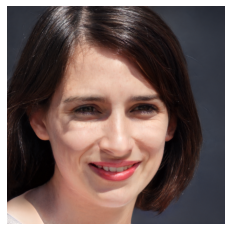

2021-09-10 03:47:07,964.964 - INFO: START IMAGE  >>> {'Bangs': 0, 'Eyeglasses': 0, 'No_Beard': 0, 'Smiling': 3, 'Young': 2}
2021-09-10 03:47:07,969.969 - INFO: 
---------------------------------------- Edit 0----------------------------------------

2021-09-10 03:47:07,976.976 - INFO: Enter your request (Press enter when you finish):


Hi, can you add bangs for her?


2021-09-10 03:47:26,129.129 - INFO: USER INPUT >>> Hi, can you add bangs for her?


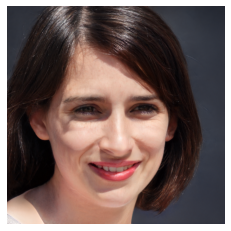

2021-09-10 03:47:27,307.307 - INFO: UPDATED IMAGE >>> {'Bangs': 3, 'Eyeglasses': 0, 'No_Beard': 0, 'Smiling': 3, 'Young': 1}
2021-09-10 03:47:27,312.312 - INFO: SYSTEM FEEDBACK >>> Is the length of the fringe ok now?
2021-09-10 03:47:27,318.318 - INFO: 
---------------------------------------- Edit 1----------------------------------------

2021-09-10 03:47:27,327.327 - INFO: Enter your request (Press enter when you finish):


no


2021-09-10 03:47:32,663.663 - INFO: USER INPUT >>> no


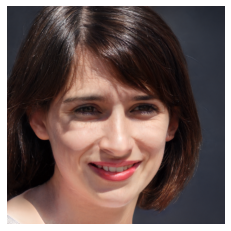

2021-09-10 03:47:34,164.164 - INFO: UPDATED IMAGE >>> {'Bangs': 4, 'Eyeglasses': 0, 'No_Beard': 0, 'Smiling': 3, 'Young': 1}
2021-09-10 03:47:34,171.171 - INFO: SYSTEM FEEDBACK >>> It's done. Maybe you would like to play with the glasses?
2021-09-10 03:47:34,180.180 - INFO: 
---------------------------------------- Edit 2----------------------------------------

2021-09-10 03:47:34,193.193 - INFO: Enter your request (Press enter when you finish):


No. Can you make her smile more happily?


2021-09-10 03:48:00,034.034 - INFO: USER INPUT >>> No. Can you make her smile more happily?


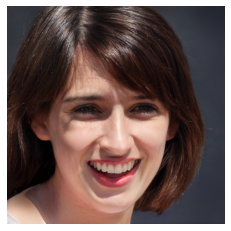

2021-09-10 03:48:01,815.815 - INFO: UPDATED IMAGE >>> {'Bangs': 4, 'Eyeglasses': 0, 'No_Beard': 0, 'Smiling': 4, 'Young': 1}
2021-09-10 03:48:01,821.821 - INFO: SYSTEM FEEDBACK >>> Well, it's done. Do you want to try editing the age?
2021-09-10 03:48:01,830.830 - INFO: 
---------------------------------------- Edit 3----------------------------------------

2021-09-10 03:48:01,834.834 - INFO: Enter your request (Press enter when you finish):


yes


2021-09-10 03:48:06,383.383 - INFO: USER INPUT >>> yes


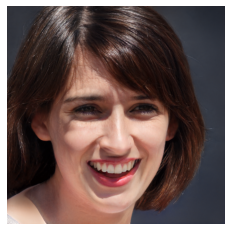

2021-09-10 03:48:12,325.325 - INFO: UPDATED IMAGE >>> {'Bangs': 4, 'Eyeglasses': 0, 'No_Beard': 0, 'Smiling': 4, 'Young': 2}
2021-09-10 03:48:12,329.329 - INFO: SYSTEM FEEDBACK >>> Is the age of the person ok now?
2021-09-10 03:48:12,332.332 - INFO: 
---------------------------------------- Edit 4----------------------------------------

2021-09-10 03:48:12,339.339 - INFO: Enter your request (Press enter when you finish):


no


2021-09-10 03:48:16,957.957 - INFO: USER INPUT >>> no


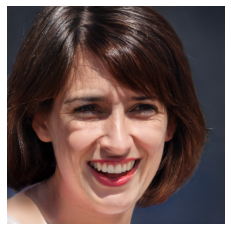

2021-09-10 03:48:24,354.354 - INFO: UPDATED IMAGE >>> {'Bangs': 4, 'Eyeglasses': 0, 'No_Beard': 0, 'Smiling': 4, 'Young': 3}
2021-09-10 03:48:24,358.358 - INFO: SYSTEM FEEDBACK >>> This is it. Is the age of the person ok now?
2021-09-10 03:48:24,360.360 - INFO: 
---------------------------------------- Edit 5----------------------------------------

2021-09-10 03:48:24,362.362 - INFO: Enter your request (Press enter when you finish):


yes!


2021-09-10 03:48:30,557.557 - INFO: USER INPUT >>> yes!
2021-09-10 03:48:30,852.852 - INFO: NO EDIT  >>> {'Bangs': 4, 'Eyeglasses': 0, 'No_Beard': 0, 'Smiling': 4, 'Young': 3}
2021-09-10 03:48:30,854.854 - INFO: SYSTEM FEEDBACK >>> Maybe you might would like to try manipulating the beard as well?
2021-09-10 03:48:30,866.866 - INFO: 
---------------------------------------- Edit 6----------------------------------------

2021-09-10 03:48:30,870.870 - INFO: Enter your request (Press enter when you finish):


no. thanks


2021-09-10 03:48:39,651.651 - INFO: USER INPUT >>> no. thanks
2021-09-10 03:48:39,950.950 - INFO: Dialog successfully ended.


In [ ]:
dialog_overall_log = dialog_with_real_user(field_model, latent_code, opt, args, dialog_logger, display_img=True)